In [16]:
import torch
import numpy as np

import matplotlib.pyplot as plt

%matplotlib inline

## Bigram model

In [17]:
# filename = 'female_names.txt'
# filename = 'pokemon_names.txt'
filename = 'names.txt'

def get_names():
    names = []
    for line in open(filename, 'r'):
        if line.startswith('#'):
            continue
        name = line.strip().lower()
        if not name:
            continue
        if not name.isalpha():
            continue
        names.append(name)
    return names

In [18]:
names = get_names()
names[:10]

names = ['emma', 'emmi', 'emilia', 'emily', 'emilio', 'emil']

In [19]:
letters = '.' + ''.join(sorted(set(''.join(names))))
num_letters = len(letters)

itol = {i: l for i, l in enumerate(letters)}
ltoi = {l: i for i, l in enumerate(letters)}

In [20]:
print(letters)
print(num_letters)

.aeilmoy
8


In [21]:
xs = []
ys = []


for word in names:
    word = ['.'] + list(word) + ['.']
    for ch1, ch2 in zip(word, word[1:]):
        ix1 = ltoi[ch1]
        ix2 = ltoi[ch2]

        xs.append(ix1)
        ys.append(ix2)

xs = torch.tensor(xs)
ys = torch.tensor(ys)

In [22]:
import torch.nn.functional as F

xenc = F.one_hot(xs, num_classes=num_letters).float()

## Set up the network and train it

In [24]:
W = torch.zeros((num_letters, num_letters), requires_grad=True).float()

In [25]:
for i in range(100):
    W.grad = None

    logits = xenc @ W
    probs = logits.softmax(dim=1)

    # the predicted probability of the correct letter
    # from our model
    ypred = probs[torch.arange(len(ys)), ys]
    loss = -(ypred.log().sum()) / len(ys)

    if i % 10 == 0:
        print(f"Iteration {i} Loss: {loss}")
    
    loss.backward()
    W.data += -10 * W.grad

Iteration 0 Loss: 2.0794413089752197
Iteration 10 Loss: 0.6789823174476624
Iteration 20 Loss: 0.6141893863677979
Iteration 30 Loss: 0.59324049949646
Iteration 40 Loss: 0.5831664204597473
Iteration 50 Loss: 0.577285885810852
Iteration 60 Loss: 0.5734422206878662
Iteration 70 Loss: 0.5707371234893799
Iteration 80 Loss: 0.5687316656112671
Iteration 90 Loss: 0.5671860575675964


In [34]:
nll = 0

for word in ['emma']:
    for ch1, ch2 in zip(word, word[1:]):
        ix = ltoi[ch1]
        iy = ltoi[ch2]
        xenc2 = F.one_hot(torch.tensor(ix), num_classes=num_letters).float()

        logits = xenc2 @ W
        print(logits.shape)
        probs = logits.softmax(dim=0)
        nll -= probs[iy].log()

print(nll)
        


torch.Size([8])
torch.Size([8])
torch.Size([8])
tensor(8.6234)


The training loop took a few tries to get right.

It took me a long time to figure out how to index into the predictions of the network `ypred` with the expected outputs `ys`. `ypred[ys]` by itself didn't work. 

But `ypred[torch.arange(len(ys)), ys]` did work. I tried it on a small toy example, before running it on the full dataset.

I also got the loss function wrong on the first try.

`ypred` is the predicted probability of the correct letter.

I thought that since I needed `ypred` to equal 1, the loss function for each example should be:

$$ \text{Loss for one example} = 1 - \text{ypred} $$

and then for all examples it should be:

$$ \text{Loss for all examples} = \sum_{\text{over all examples}}{\log (1 - \text{ypred})} $$

But it turns out the second statement is wrong. If `ypred` equals 1, we'll end up taking $\log 0$ for each example, which is $-\infty$.

Instead, the correct loss functions are as follows:

$$ \text{Loss for one example} = -\log \text{ypred} $$

$$ \text{Loss for all examples} = \sum_{\text{over all examples}}{-\log \text{ypred}} $$

This gives us a loss of 0 when the results are perfect, and a positive loss otherwise.


## Sampling words from our model

In [26]:
g = torch.Generator().manual_seed(2147483647)

W = torch.randn((num_letters, num_letters))

for i in range(100):
    letter = '.'

    word = ''

    while True:
        predxenc = F.one_hot(torch.tensor(ltoi[letter]), num_classes=num_letters).float()

        logits = predxenc @ W
        probs = logits.softmax(dim=0)

        next_letter_ix = torch.multinomial(probs, num_samples=1, replacement=True, generator=g)
        letter = itol[next_letter_ix.item()]

        if letter == '.':
            break

        word += letter
    print(word)

oom

yy
omliomomym
y
omemo
om
ia
oemoeyy
yme
o
ioae
oa
laliaa
omolioeeoaaaooal
m
ey
a
oeyy
oeem
ooalie
omai
e

i
aailime

yyyy
oeimomoo
iye
yiomii
oaeyyylyyome
omlim
yomoa
om
iooaaaioyymoo
yymie
aoaa
om
o
oaaimemlimel
om
oy
ioymo
ylaaaae
oaoyyyliyymmoal
y
yo

oomeliymoaioa
om
imey
imeyi
y
im
ymaa
yiio
omm
ooe
iyylimo
oaio
oaali
em
e
omoa
em
a
oaioaii
oeeyioyai
ym
oaaoaaoe

iime
oey
oo
elyyomom
ioa
em
lmoe
yyyoe
ae
ae

ooaemalme
o
o
y
o
ioaeiymo

llmomoaliimiiiom
ei
yomem
m
oomoeyy
oeyaeiimy
l
oaa
lme
m


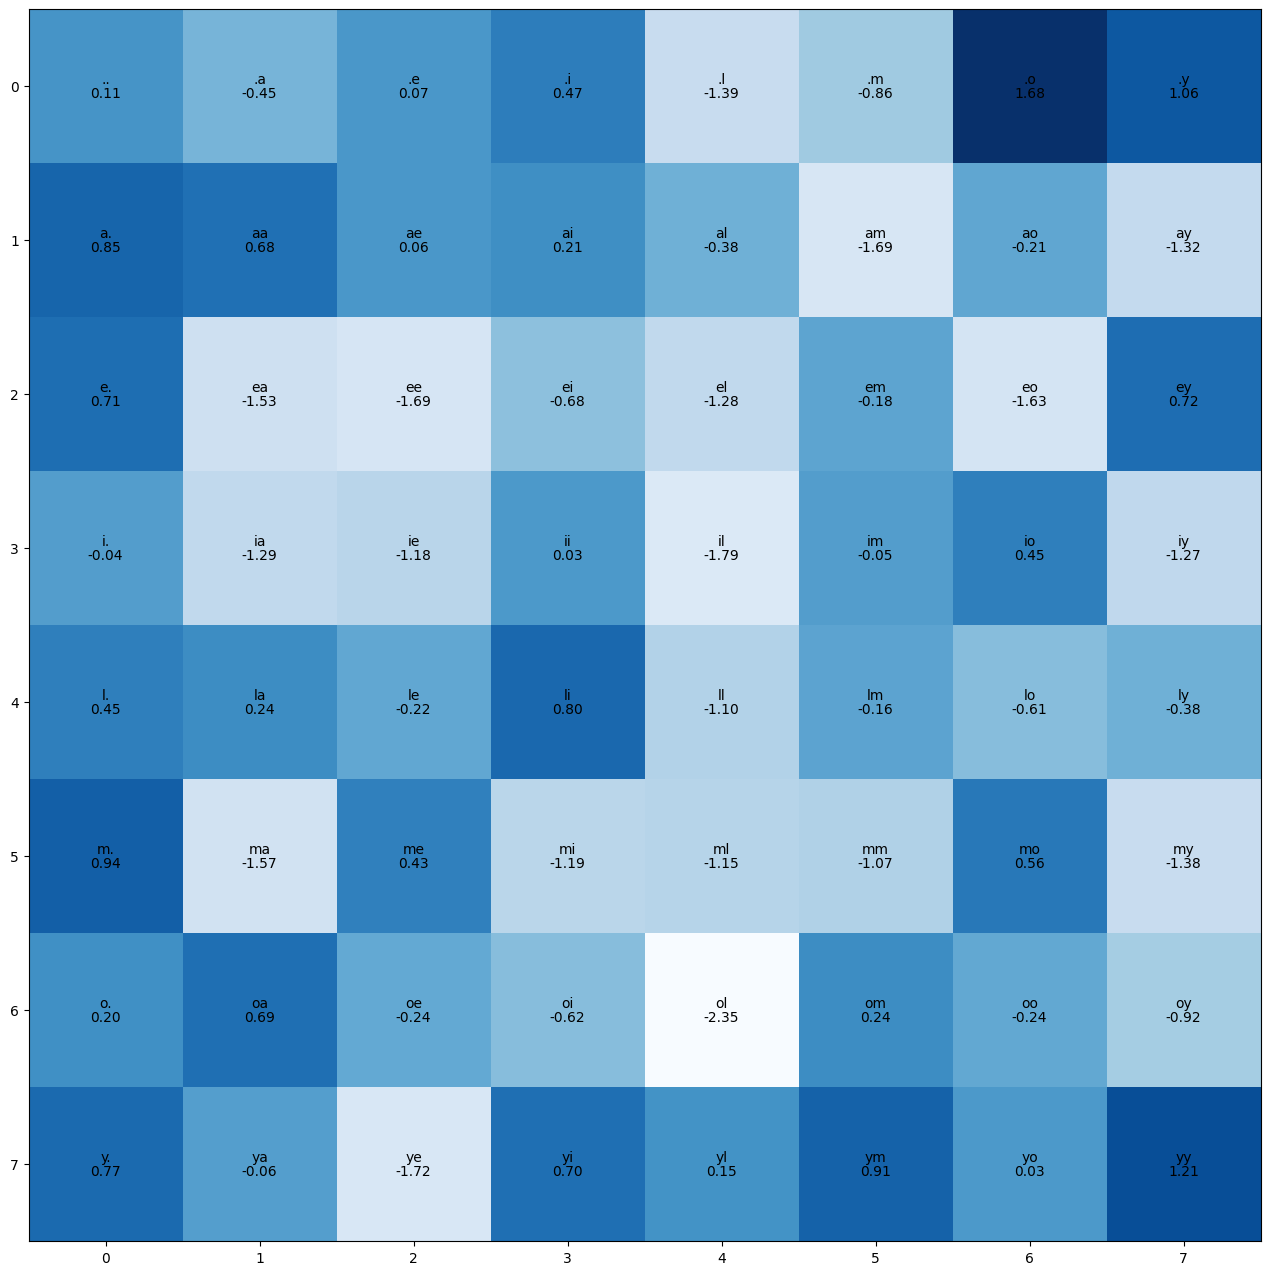

In [27]:
W2 = W.detach().numpy()
plt.figure(figsize=(16, 16))
plt.imshow(W2, cmap='Blues')
for i in range(num_letters):
    for j in range(num_letters):
        plt.text(j, i, f"{W2[i][j]:.2f}", va='top', ha='center')
        plt.text(j, i, f"{letters[i]}{letters[j]}", va='bottom', ha='center')

